# Dolphin walkthrough for OPERA geocoded CSLCs

This notebook demonstrates the basic usage of the `dolphin` command line tool to execute the stack-based phase linking workflow.
In this notebook, we will

- Download geocoded, co-registered single-look complex (CSLC) radar images from [ASF](https://search.asf.alaska.edu/)
- Prepare a configuration file for a stack of coregistered single-look complex (SLC) radar images with `dolphin config`
- Run this configuration file with `dolphin run` 
- Inspect the resulting output interferograms
- Show the most common parameters you may want to change or customize



## Setup

We first need to install `dolphin` as outlined in the [Getting Started](https://dolphin-insar.readthedocs.io/en/latest/getting-started/) section of the documentation. You can install `dolphin` with either `conda` (recommended) or `pip` (if a `gdal` installation is availble to the environment)


We can check that we have the command line tool correctly installed by running:

In [1]:
!dolphin --help

usage: dolphin [-h] {run,config,unwrap,timeseries,filter}

╭─ options ──────────────────────────────────────────────────────────────────╮
│ -h, --help        show this help message and exit                          │
╰────────────────────────────────────────────────────────────────────────────╯
╭─ subcommands ──────────────────────────────────────────────────────────────╮
│ {run,config,unwrap,timeseries,filter}                                      │
│     run           Run the displacement workflow.                           │
│     config        Create a configuration file for a displacement workflow. │
│     unwrap        Run snaphu on all interferograms in a directory.         │
│     timeseries    Invert the unwrapped interferograms, estimate timeseries │
│                   and phase velocity.                                      │
│     filter        Filter a list of unwrapped interferogram files using a   │
│                   long-wavelength filter.                             

or by importing dolphin in python

In [2]:
import dolphin

dolphin.show_versions()

dolphin version: 0.42.0

Python deps:
        h5py: 3.14.0
         jax: 0.7.0
       numba: 0.61.2
       numpy: 2.2.6
 opera-utils: 0.24.0
    pydantic: 2.11.7
      pyproj: 3.7.2
    rasterio: 1.4.3
 ruamel_yaml: None
       scipy: 1.16.1
      snaphu: 0.4.1
threadpoolctl: 3.6.0
        tqdm: 4.67.1
        tyro: 0.9.28
  osgeo.gdal: 3.10.3

System:
      python: 3.12.11 | packaged by conda-forge | (main, Jun  4 2025, 14:45:31) [GCC 13.3.0]
  executable: /home/jovyan/.local/envs/dolphin_env/bin/python
     machine: Linux-6.12.37-61.105.amzn2023.x86_64-x86_64-with-glibc2.35
Unwrapping packages:
snaphu : 0.4.1
spurt : None
isce3 : None
tophu : None
whirlwind : None
      snaphu: 0.4.1
       spurt: None
       isce3: None
       tophu: None
   whirlwind: None
optional GPU info:
         jax: 0.7.0
gpu_is_available: False


If you have a GPU available to you, you can follow the [extra installation set up](https://dolphin-insar.readthedocs.io/en/latest/gpu-setup/) so that the GPU verion of the workflow run.
This can be 5-20x faster than the CPU version for the phase linking portion, depending on the size of your workstation.
Here we will be processing a relatively small area, so the CPU will suffice.

## Input dataset

To find input data, you can use the [ASF search UI](https://search.asf.alaska.edu/) to explore and get a list of URLs to download; for our purposes, we will use the [OPERA Co-regisred Single-look Complex product](https://www.jpl.nasa.gov/go/opera/products/cslc-product-suite), which `dolphin` can directly process.

The helper functions in the [`opera-utils`](https://github.com/opera-adt/opera-utils) library provide wrappers over the [ASF library](https://github.com/asfadmin/Discovery-asf_search) to make it easy to download OPERA CSLCs over a certain region.
Additionally, `opera-utils` has the ability to filter queries with "missing bursts" (due to irregular Sentinel-1 acquisitions over North America) to ensure that all dates present have the same spatial coverage.

We will search for a stack of Sentinel-1 SLCs over New Orleans (ascending track 165).

Since ASF requires a login to download data, you must authenticate with your Earthdata credentials.
We will assume that a `~/.netrc` file is set up with the correct permissions.

In [3]:
from pathlib import Path

import shapely
import opera_utils.download

aoi = "POLYGON((-90.3038 29.8923,-90.0278 29.8992,-90.0262 30.0538,-90.3205 30.06,-90.3038 29.8923))"
start = "2022-01-01"
end = "2023-01-01"
burst_ids = ["T165-352434-IW2", "T165-352435-IW2"]
bounds = shapely.from_wkt(aoi).bounds


results, options = opera_utils.download.search_cslcs(
    burst_ids=burst_ids,
    start=start,
    end=end,
    # We want to have the same set of dates for each Burst ID (spatial footprint)
    check_missing_data=True,
    # We have already picked out the Burst Ids that we will use.
    # An alternative is to use a WKT polygon, with or without a track number specified
    # aoi_polygon=aoi,
)
best_option = options[0]
print(f"Found {len(best_option.inputs)} CSLCs to download between {start} and {end}")


/home/jovyan/.local/envs/dolphin_env/lib/python3.12/site-packages/tzlocal/unix.py:198: UserWarning: Can not find any timezone configuration, defaulting to UTC.
  warnings.warn("Can not find any timezone configuration, defaulting to UTC.")


Found 44 CSLCs to download between 2022-01-01 and 2023-01-01


In [4]:
import os

import asf_search as asf

work_dir = Path("new-orleans")
work_dir.mkdir(parents=True, exist_ok=True)
os.chdir(work_dir)

slc_dir = Path("input_slcs")
slc_dir.mkdir(parents=True, exist_ok=True)
asf.download_urls(best_option.inputs, path=slc_dir)

In the `input_slcs` directory, we have stored the NetCDF-format SLCs:

In [5]:
!ls input_slcs | head -3

OPERA_L2_CSLC-S1_T165-352434-IW2_20220108T000229Z_20240731T082832Z_S1A_VV_v1.1.h5
OPERA_L2_CSLC-S1_T165-352434-IW2_20220120T000228Z_20240731T110350Z_S1A_VV_v1.1.h5
OPERA_L2_CSLC-S1_T165-352434-IW2_20220201T000228Z_20240731T144900Z_S1A_VV_v1.1.h5


See the [OPERA CSLC documentation](https://d2pn8kiwq2w21t.cloudfront.net/documents/OPERA_CSLC-S1_ProductSpec_v1.0.0_D-108278_Initial_2023-09-11_URS321269.pdf) for the full filename convention, but the main points are

- `T165` is Sentinel-1 track (relative orbit) 165
- 352434 the Burst IDs from [ESA's Burst database](https://sar-mpc.eu/test-data-sets/)
- `IW2` indicates these are from the first subswath (since the "Burst ID" is repeated for subswaths IW1,2,3.)
- `20220108T000229Z` is the acquisition datetime (in UTC)

Note that we specified the data we want is in `/data/VV`. This is not necessary for other SLC formats (e.g. binary files from ISCE2) which have only one raster layer.

You can process one single stack, or multiple geocoded stacks. If you have different spatial regions, as is the case with OPERA CSLCs, `dolphin` will form burst-wise interferograms and stitch them before unwrapping.

Let's make a configuration file for all of the bursts:

In [6]:
!dolphin config --slc-files input_slcs/*.h5 --subdataset "/data/VV"

Saving configuration to dolphin_config.yaml


You can inspect the YAML file to see all configuration options.

### Common configuration

#### Strides
You can create a downsampled version of the output using `--output-options.strides.x` (or `--sx` for short) and `--sy`. 
This will save time/space by creation an output with coarser pixel spacing than your SLCs.
For COMPASS outputs, adding `--sx 6 --sy 3` will convert the inputs at (5m, 10m) in `(x, y)` (aka `(easting, northing)`) to a (30 meter, 30 meter) output.


#### Specify the working directory

Use `--work-directory` to save all rasters to a different directory other than the one you call `dolphin run` from.

#### Specify how many bursts, or patches, to process in parallel

By adding the `--n-parallel-bursts`, you can process separate geocoded bursts at the same time (assuming sufficient resources are available). On a large single stack (like the flat binary files from isce2, or NISAR swaths), this option controls the number of parallel blocks to process during phase linking.

Additionally, use `--threads-per-worker` to limit the number of CPUs you would like the workflow to use, especially on large workstations.

#### Mini-stack size for phase linking

When processing many (dozens to hundreds) of SLCs, `dolphin` will use the strategy of batching SLCs into "mini-stacks", rather than processing the entire stack at once. The default is to use batch of 15 dates at a time, but this can be changed with `--phase-linking.ministack-size` or `--ms`. For example, you may want to try processing all dates at once (likely a slower processing time), or you may want to adjust the number slightly (if, e.g., you have 46 dates and would rather not leave the last batch with one remaining).

#### Phase unwrapping

`dolphin` supports multiple options for phase unwrapping. Here, we will use the [Python wrapper for SNAPHU](https://github.com/isce-framework/snaphu-py), one of the most widely used phase unwrapping algorithms.

#### Bounds subsetting

If you are interested in a smaller subset of the area, you can specify the `--output-bounds` to force the raster boundaries.

In [7]:
!aws s3 cp s3://earthscope-insar2025/dolphin-opera-cslcs/water_mask.tif ./

download: s3://earthscope-insar2025/dolphin-opera-cslcs/water_mask.tif to ./water_mask.tif


In [30]:
%%bash
dolphin config \
    --slc-files input_slcs/*.h5 \
    --subdataset "/data/VV" \
    --mask-file water_mask.tif \
    --sx 6 --sy 3 \
    --interferogram-network.max-bandwidth 3 \
    --n-parallel-bursts 2 \
    --ms 16 \
    --unwrap-options.n-parallel-jobs 3 \
    --output-options.bounds -90.3205 29.8923 -90.0262 30.06 \
    --unwrap-options.snaphu-options.ntiles 2 2 --unwrap-options.snaphu-options.tile-overlap 400 400 \
    --unwrap-options.snaphu-options.n-parallel-tiles 4 \
    --work-directory dolphin


Saving configuration to dolphin_config.yaml


## Running the workflow

Now that we have created the `dolphin_config.yaml` file, we can run it using `dolphin run`

In [ ]:
%%capture outputs
# To see all the output logging, remove the line above

import os

# TQDM doesn't play nicely with notebook outputs, not like terminal
# os.environ["TQDM_DISABLE"] = "1"

# Running from the command line
# !dolphin run dolphin_config.yaml

# Running within python:
from dolphin.workflows import displacement, DisplacementWorkflow
cfg = DisplacementWorkflow.from_yaml("dolphin_config.yaml")
displacement.run(cfg)

## Visualizing the displacement

The outputs can be plotted using any tool capable of reading GDAL-compatible rasters. You can also use the `dolphin.io.load_gdal` function for convenience.


In [33]:
file_list = sorted(Path("dolphin/timeseries/").glob("2*.tif"))
print(f"Found {len(file_list)} timeseries files")

Found 21 timeseries files


In [46]:
import matplotlib.pyplot as plt
import numpy as np
from opera_utils import get_dates

from dolphin.io import load_gdal

%matplotlib inline

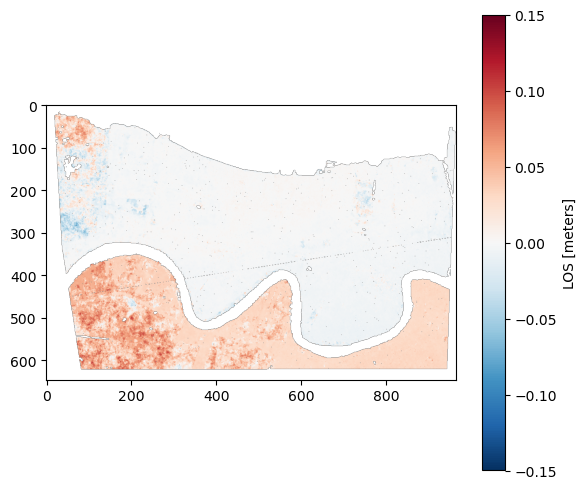

In [48]:
fig, ax = plt.subplots(figsize=(6, 5))

last_displacement = load_gdal(file_list[-1], masked=True)

axim = ax.imshow(
    last_displacement - np.ma.median(last_displacement),
    cmap="RdBu_r",
    vmax=0.15,
    vmin=-0.15,
)
fig.colorbar(axim, label="LOS [meters]")

fig.tight_layout()

### Apppendix: More on the output folders

For each stack of SLCs (which may be > 1 when processing OPERA geocoded burst SLCs), the workflow creates a folder for
1. persistent scatter outputs (`PS`)
2. linked phase optimized SLCs (`linked_phase`)
3. (virtual) interferograms formed using the optimized SLCs (`interferograms`)

Here we have two of these subdirectories named `t042_088905_iw1` and `t042_088906_iw1`.
At the top level, we have
- The `slc_stack.vrt` is a VRT file pointing to the input SLCs for that burst stack.
- The `nodata_mask.tif` has been created from the OPERA CSLC metadata to skip over the nan regions
- The `bounds_mask.tif` was created to more quickly process a subset of the CSLCS.

Last, there are a top-level directorie for `interferograms` that have been stitched together, `unwrapped` folder for the outputs of phase unwrapping, and `timeseries` for the result of inverting in unwrapped interferograms (if a network of redundant interferograms were created).

```
$ tree -L 1 work-walkthrough/
work-walkthrough/
├── dolphin.log
├── interferograms
├── t078_165573_iw2
├── t078_165574_iw2
├── timeseries
└── unwrapped

$ tree -L 1 work-walkthrough/t078_165574_iw2/
work-walkthrough/t078_165574_iw2/
├── PS
├── bounds_mask.tif
├── combined_mask.tif
├── interferograms
├── linked_phase
├── nodata_mask.tif
├── slc_stack.vrt
├── timeseries
└── unwrapped
    
```